In [2]:
import time
import math 
import copy
import random
import statistics

##Run KNN Simulation

In [6]:
##This has its own cell block because it takes a long time to run
loadFiles()

Done key.csv
Done train.csv
Done weather.csv


In [30]:
global kNum 
kNum = 3

notedDays = buildNotedDaysHash(keyDict, weatherDict)
trainedPreStoreDict = buildPredictorTargetArr(keyDict, trainDict, notedDays, weatherDict)
dataList = changeDateCreateKNNList(trainedPreStoreDict)
trainingData, testData = createTestAndTrain(dataList)
tempStdev = calculateSTDEV(trainingData)
simDict, temp = sim(trainingData, testData, tempStdev)
predictedDict = runCalcAcross(kNum, simDict)
runNumRSMLEAcross(predictedDict, testData)

Done
2012-12-25 Failed
2012-12-25 Failed
Done
Done
Done
17.18932725886405
Done
Done
[0.0, 0.1808907779673747, 0.21057067025519124, 0.3255474012702359, 0.0, 0.05556047910420744, 0.6500252203913097, 0.6492689627862235, 0.0, 0.19272088287339828, 0.4741155803680206, 0.0684474714921343, 0.3714108417475282, 0.530164951998753, 0.0, 0.0, 0.1895699938498879, 0.04043322854674207, 0.0, 0.48268459128925534, 0.3799494624934701, 0.11775091246941596, 0.495611929691607, 0.49319221808117236, 0.257318454427777, 0.0, 0.2577591068036898, 0.0, 0.0, 0.2389808043072347, 0.12001645058530504, 0.10588507504153565, 0.1306934778617096, 0.3209188928837835, 0.12110200181723256, 0.0, 0.0, 0.16602266173664326, 0.41656832194351134, 0.0, 0.0, 0.1055008305469868, 0.22733983527676035, 0.0, 0.12576940973692421, 0.47818017195581874, 0.2598822777442244, 0.29199582031631033, 0.09896330648987217, 0.0, 0.45174291263916994, 0.17899416663611042, 0.3027085919346371, 0.487999966748988, 0.0, 0.1920069394006067, 0.3982372436504827, 

In [3]:
def loadData(fname, dataStructure):
    count = 0
    with open(fname) as f:
        content = f.readlines()
    for line in content:
        if count is not 0:
            line = line.strip()
            line = line.split(',')
            if dataStructure.get(line[0]) is None:
                dataStructure[line[0]] = []
                dataStructure[line[0]].append(line[1:])
            else:
                dataStructure[line[0]].append(line[1:])
        count+=1
    print("Done " + fname)
        
def loadFiles():
    global keyDict, trainDict, weatherDict
    keyDict = {}
    weatherDict = {}
    trainDict = {}
    dataStruct = [keyDict, trainDict, weatherDict]
    count=0
    for x in ['key.csv', 'train.csv', 'weather.csv']:
        loadData(x, dataStruct[count])
        count+=1

loadFiles()

Done key.csv
Done train.csv
Done weather.csv


##Define Weather Event
weather event as any day in which more than an inch of rain or two inches of snow was observed

In [4]:
def buildNotedDaysHash(keyDict, weatherDict):
    toreturn = {}
    for storeKey in range(1,46):
        stationKey = keyDict[str(storeKey)][0][0]
        weatherData = weatherDict[str(stationKey)]
        first = True
        for dayData in weatherData:
            isNoted = 0
            try:
                if float(dayData[12]) > 2:
                    isNoted = dayData
            except ValueError:
                pass
            try:
                if float(dayData[13]) > 1:
                    isNoted = dayData
            except ValueError:
                pass
            if first:
                toreturn[storeKey] = []
                toreturn[storeKey].append(isNoted)
                first = False
            else:
                toreturn[storeKey].append(isNoted)
    print("Done")
    return toreturn
            
global notedDays 
notedDays = buildNotedDaysHash(keyDict, weatherDict)

Done


In [9]:
def buildPredictorTargetArr(keyDict, trainDict, notedDays, weatherDict):
    indexJump = 3
    arrSize = 115
    toreturn = {}
    for storeKey in range(1,46):
        dayArr = notedDays[storeKey]
        for x in dayArr:
                if x != 0:
                    if toreturn.get(storeKey) is None:
                        tempArr = [0]*arrSize
                        tempdate = x[0]
                        tempArr[0] = tempdate
                        tempArr[1] = int(keyDict[str(storeKey)][0][0])
                        tempArr[3] = storeKey
                        try:
                            tempArr[2] = int(x[3])
                        except ValueError:
                            tempArr[2] = 'N/A'
                        try:
                            tempIter = trainDict[tempdate]
                        except KeyError:
                            print(str(x) + " Failed")
                        for i in tempIter:
                            if int(i[0]) == storeKey:
                                tempIndex = int(i[1]) + indexJump
                                tempArr[tempIndex] = int(i[2])
                        toreturn[storeKey] = []
                        toreturn[storeKey].append(tempArr)
                    else:
                        tempdate = x[0]
                        try:
                            tempIter = trainDict[tempdate]
                        except KeyError:
                            print(str(x[0]) + " Failed")
                        tempArr = [0]*arrSize
                        tempArr[0] = tempdate
                        tempArr[1] = int(keyDict[str(storeKey)][0][0])
                        tempArr[3] = storeKey
                        try:
                            tempArr[2] = int(x[3])
                        except ValueError:
                            tempArr[2] = 'N/A'
                        for i in tempIter:
                            if int(i[0]) == storeKey:
                                tempIndex = int(i[1]) + indexJump
                                tempArr[tempIndex] = int(i[2])
                        toreturn[storeKey].append(tempArr)
    print("Done")
    return toreturn

global trainedPreStoreDict
trainedPreStoreDict = buildPredictorTargetArr(keyDict, trainDict, notedDays, weatherDict)

2012-12-25 Failed
2012-12-25 Failed
Done


##Notes

No Train data available for days that the store is closed (ie Chirstmas) 

In [10]:
def changeDateCreateKNNList(trainedPreStoreDict):
    dataList = []
    for key,value in trainedPreStoreDict.items():
        for x in range(len(value)):
            try:
                tempDate = trainedPreStoreDict[key][x][0]
                struct_time = time.strptime(tempDate, "%Y-%m-%d")
                trainedPreStoreDict[key][x][0] = struct_time.tm_yday
                dataList.append(trainedPreStoreDict[key][x])
            except TypeError:
                print("AlreadyFormatted")
                break
    print("Done")
    return dataList
        
global dataList
dataList = changeDateCreateKNNList(trainedPreStoreDict)

Done


In [13]:
def createTestAndTrain(data):
    trainingData = copy.deepcopy(data)
    testData = []
    for i in range(len(trainingData)//10):
        testData.append(trainingData.pop(random.randint(0, len(trainingData)-1)))
    print("Done")
    return trainingData, testData

global trainingData, testData
trainingData, testData = createTestAndTrain(dataList)

Done


In [14]:
def calculateSTDEV(trainingData):
    tempCalc = []
    for x in trainingData:
        if x[2] != 'N/A':
            tempCalc.append(x[2])
    stDev= statistics.stdev(tempCalc)
    print(stDev)
    return stDev

global tempStdev
tempStdev = calculateSTDEV(trainingData)

17.4151230621909


In [17]:
def sim(trainingData, testData, tempStdev):
    simDictFORPLOT = {}
    numberOfPredictors = 4
    tempIndexTest = 0 
    testKScoredArr = {}
    for compare in testData:
        simArr = []
        simArrFORPLOT= []
        for x in trainingData:
            tempScore = 0
            dateDist = abs(compare[0] - x[0])
            tempScore += 10 - (dateDist/365)*10
            if x[2] != 'N/A' and compare[2] != 'N/A':
                tempuratureDist = abs(compare[2] - x[2])
                tempScore += 10 - (tempuratureDist/tempStdev)*10
            if x[1] == compare[1]:
                tempScore += 3
            if x[3] == compare[3]:
                tempScore += 1
            simArr.append((float(tempScore), x[numberOfPredictors:]))
            simArrFORPLOT.append((float(tempScore), x))
        simArr.sort()
        simArrFORPLOT.sort()
        simArr.reverse()
        simArrFORPLOT.sort()
        testKScoredArr[tempIndexTest] = simArr
        simDictFORPLOT[tempIndexTest] = simArrFORPLOT
        tempIndexTest+=1
    print("Done")
    return testKScoredArr, simDictFORPLOT

global simDict, simDictFORPLOT
simDict, simDictFORPLOT = sim(trainingData, testData, tempStdev)

Done


In [18]:
def runCalcAcross(k, simDict):
    predictedDict = {}
    for key,val in simDict.items():
        tempPredArr = calcUnits(k, val)
        predictedDict[key] = tempPredArr
    print("Done")
    return predictedDict

def calcUnits(k, simArr):
    workDict = simArr[:k]
    kmax = max(workDict)[0]
    weightTot = 0
    predictedArr = [0]*111
    wieghtSumArr = [0]*111
    for x in workDict:
        itemsArr = x[1] 
        weight = (x[0]/kmax)
        weightTot += weight
        for i in range(111):
            wieghtSumArr[i] = wieghtSumArr[i] + (itemsArr[i]*weight)
    for i in range(111):
            predictedArr[i] = (wieghtSumArr[i]/weightTot)
    return predictedArr
    
global predictedDict
predictedDict = runCalcAcross(kNum, simDict)

Done


In [20]:
def runNumRSMLEAcross(predictedDict, compareTotalArr):
    numberOfPredictors = 4
    global RSMLEList
    RSMLEList = []
    for key,val in predictedDict.items():
        RSMLEList.append(EvaluationNumRSMLE(val, compareTotalArr[key][numberOfPredictors:]))
    print(RSMLEList)
    print(statistics.mean(RSMLEList))

def EvaluationNumRSMLE(predictedArr, compareSingleArr):
    tempLog = 0
    for x in range(111):
        tempLog = tempLog + (math.log(predictedArr[x] + 1) - math.log(compareSingleArr[x] + 1))**2
    toRoot = (1/111)*tempLog
    RSMLE = math.sqrt(toRoot)
    return RSMLE
    
runNumRSMLEAcross(predictedDict, testData)

[0.025949394160080907, 0.3509339137311181, 0.572572663548479, 0.5622269621990462, 0.2782637016858113, 0.34489561849211675, 0.1880435440283364, 0.15216421688620402, 0.16929615667510398, 0.0, 0.4599421981473251, 0.49112664716167603, 0.34516985697422314, 0.0, 0.5694601003970989, 0.611299427742467, 0.0, 0.0, 0.43687850373195775, 0.19340281863742875, 0.0, 0.0, 0.2770884219948116, 0.5339021816174491, 0.26365795318648044, 0.0, 0.2376225153870351, 0.0880555175927004, 0.3065822081594456, 0.5694710873147706, 0.0, 0.23329920236030535, 0.0, 0.23829373722055838, 0.4385877017911693, 0.0, 0.7485761695773369, 0.028085524032750286, 0.4781463311110113, 0.2799490592661326, 0.0, 0.0, 0.14349384050648364, 0.0, 0.38002487215346176, 0.5418757911857411, 0.21805141232421765, 0.45186006315422383, 0.48477523549571283, 0.48081894758036553, 0.11978434121799078, 0.0, 0.14120924864838422, 0.0, 0.20160381104300107, 0.0, 0.0, 0.0, 0.5417150987502349, 0.3982784941552543, 0.0, 0.5435656064983491, 0.0, 0.3820326282218668

#Deeper Analysis / Graph Section

In [54]:
def formatDataPlot(simDict, predictedDict, testData, k):
    plotFormat = {}
    for key in range(128):
        plotFormat[key+1] = [testData[key]]+[predictedDict[key]]+[simDict[key][:k]]
    print("Done")
    return plotFormat

# RSMLEList other useful Data Structure
hashFormatted = formatDataPlot(simDictFORPLOT, predictedDict, testData, kNum)

Done


#BELOW THIS IS WORK DONE BUT NEVER USED

In [33]:
def keyDictForKNN(keyDict):
    modKeyDict = {}
    dictList = []
    for key,values in keyDict.items():
        tempVal = int(values[0][0])
        tempKey = int(key)
        if tempKey not in dictList:
            dictList.append(tempKey)
            modKeyDict[tempKey] = tempVal
    print("Done")
    return modKeyDict


global modKeyDict        
modKeyDict = keyDictForKNN(keyDict)

Done


In [8]:
def KNNCatagoryHashGen(dataList, modKeyDict):
    wTowerCatagoryHash = {}
    dayCatagoryHash = {}
    for x in dataList:
        stationKey = modKeyDict[x[1]]
        dayNum = x[0]
        dayCatagoryHash = insertdayCatagoryHash(dayCatagoryHash, dayNum, x)
        wTowerCatagoryHash = insertwTowerCatagoryHash(wTowerCatagoryHash, stationKey, x)
    print("Done")
    return dayCatagoryHash, wTowerCatagoryHash
        
def insertdayCatagoryHash(dayCatagoryHash, dayNum ,x):
    if dayCatagoryHash.get(dayNum) is None:
        dayCatagoryHash[dayNum] = []
        dayCatagoryHash[dayNum].append(x)
    else:
        dayCatagoryHash[dayNum].append(x)
    return dayCatagoryHash
    
def insertwTowerCatagoryHash(wTowerCatagoryHash, stationKey, x):
    if wTowerCatagoryHash.get(stationKey) is None:
        wTowerCatagoryHash[stationKey] = []
        wTowerCatagoryHash[stationKey].append(x)
    else:
        wTowerCatagoryHash[stationKey].append(x)
    return wTowerCatagoryHash
        
        
global dayCatagoryHash, wTowerCatagoryHash
[dayCatagoryHash, wTowerCatagoryHash] = KNNCatagoryHashGen(dataList, modKeyDict)
global featureSet
featureSet = [dayCatagoryHash, wTowerCatagoryHash]

Done


In [11]:
%matplotlib inline

import matplotlib

import numpy as np

import matplotlib.pyplot as plt

print("Done")

Done


ValueError: x and y must have same first dimension

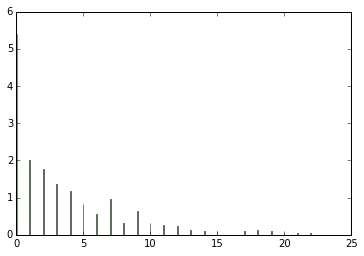

In [47]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


dayArr = [0]*364
towArr = [0]*20

for key,val in dayCatagoryHash.items():
    dayArr[key-1] = len(val)
    
for key,val in wTowerCatagoryHash.items():
    towArr[key-1] = len(val)

# # example data
mu = 100 # mean of distribution
sigma = 15 # standard deviation of distribution
# x = mu + sigma * np.random.randn(10000)

num_bins = 365
# the histogram of the data
n, bins, patches = plt.hist(dayArr, num_bins, normed=1, facecolor='green', alpha=0.5)
# add a 'best fit' line
y = num_bins
plt.plot(bins, n, 'r--')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2 # 0 to 15 point radiuses

# print(x)
# print(y)
# print(colors)
# print(area)

dayArr = [0]*364
towArr = [0]*20

for key,val in dayCatagoryHash.items():
    dayArr[key-1] = len(val)
    
count=0
countI=0
dayArrAdjust=[0]*20
for x in dayArr:
    dayArrAdjust[countI] = dayArrAdjust[countI] + x
    if count%19 == 18:
        countI+=1
    count+=1
    
    
print(dayArrAdjust)

for key,val in wTowerCatagoryHash.items():
    towArr[key-1] = len(val)
    
print(towArr)
print(colors[:20])

Darea = [0]*20
Tarea = [0]*20
Farea = [0]*20
for x in range(towArr):
    Tarea[x]=towArr[x]/max(towArr)
    
for x in range(dayArrAdjust):
    Darea[x]=dayArrAdjust[x]/max(dayArrAdjust)
    
for x in range(Tarea):
    Farea[x] = (Tarea[x]+Darea[x])/2
print(Farea)

plt.scatter(dayArrAdjust, towArr, s=area, c=colors, alpha=0.5)
plt.show()

In [ ]:
def sim(featureSet, comp, temp):
    ksd = simDay( featureSet[0], comp[0], temp[0] ) 
    kwt = simWTower( featureSet[1], comp[1], temp[1] ) 
    
    
def simDay( dayCatagoryHash, compDay, tempDay):
    for key,val in dayCatagoryHash.items():
        sVal = key - 
        